# Stochastic Simulation

*Winter Semester 2024/25*

10.01.2025

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 08
</h3>

---

<h1 align="center">
Control Variates and Stratification
</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact
from scipy.stats import norm
from tqdm.notebook import tqdm
from typing import Tuple, List

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Exercise 1

Suppose we wish to construct a Brownian motion path
$\{B_t\colon B_0=0,\, 0\le t\le T\}$ that finishes at $T= 1$ in $S$
distinct strata. To stratify standard Brownian motion on its endpoint,
one first generates the $S$ values at $T=1$ and then samples the
Brownian paths on the interval $[0,T]$ conditional upon these
stratified terminal values.

1. Implement an algorithm that generates
	stratified standard Brownian motion using $S$ equiprobable
	strata. Specifically, for each stratum $\Omega_j$, $j=1,\dots,S$,
	your algorithm should produce $N_j$ stratified Brownian samples
	paths $B_{t_m}^{(i,j)}$, $i=1,\dots,N_j$, evaluated in the discrete
	times $t_m = m/M$ with $m=1,\dots, M\in\mathbb{N}$. Test your
	implementation for $S=12$, $M=1000$, and $N_j=2$ by plotting the
	stratified samples paths.

    **Hint:** Brownian bridge sampling.

In [3]:
def brownian_bridges(terminal_values: np.array, M: int) -> np.array:
    """
    Generates Brownian bridges using `M` sample points that
    start in 0 and end in given `terminal_values`.
    """
    t = np.linspace(0, 1, M)
    dt = t[1] - t[0]

    N = len(terminal_values)    
    W = np.zeros((N, M))
    W[:, 1:] = np.sqrt(dt) * np.random.randn(N, M - 1).cumsum(axis=1)
    
    B = W + t * (terminal_values - W[:, -1]).reshape(-1, 1)

    return B

In [4]:
def stratified_brownian_motions(S: int, N: np.array, M: int, T: float=1) -> np.array:
    """
    Generates stratified Brownian motions with `S` strata and `M` sample points.
    The array of sample sizes in each stratum is given by `N`.
    """
    U = []
    for j in range(S):
        low = j / S
        high = (j + 1) / S
        U.append(np.random.uniform(low, high, size=N[j]))
    U = np.hstack(U)
    
    terminal_values = norm.ppf(U, loc=0, scale=np.sqrt(T))
    paths = brownian_bridges(terminal_values, M)

    return paths

In [5]:
def plot_strat_brownian_motions(S: int, N: int):
    """Interaction helper."""
    N = N * np.ones(S).astype(int)
    M = 1000
    T = 1
    x = stratified_brownian_motions(S, N, M, T)

    t = np.linspace(0, T, M)

    s = 0
    e = 0
    for j, Nj in enumerate(N):
        e += Nj
        plt.plot(t, x[s:e].T, "C" + str(j))
        s = e

    plt.xlabel("$t$")
    plt.ylabel("$B_t^{(i, j)}$")
    plt.title("Stratified Brownian motions")

interact(plot_strat_brownian_motions, S=np.arange(3, 13), N=np.arange(2, 11));

interactive(children=(Dropdown(description='S', options=(3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=3), Dropdown(…

2. Consider the geometric Brownian motion process $X_t$ that solves
	\begin{equation*}
	dX= rX\,dt + \sigma X\,dW\;,\quad X(0) = X_0\;,
	\end{equation*}
	and which is given by $X_t = X_0e^{Y_t}$, where
	$Y_t = (r-\sigma^2/2)t + \sigma W_t$ with $W$ being a standard
	Wiener process. For $M\in\mathbb{N}$, let
	\begin{equation*}
	\Psi\bigl(X_{t_0},\dots , X_{t_M}\bigr) = \max_{0\le m\le M}X_{t_m} - \min_{0\le m\le M}X_{t_m}\;,
	\end{equation*}
	where $t_m=m/M$ as before.  We want to estimate
	$\mu = \mathbb{E}\bigl[\Psi\bigl(X_{t_0},\dots , X_{t_M}\bigr)\bigr]$ for
	$X_0=6$, $r=0.05$, $\sigma = 0.3$, and $M=100$. Use your procedure
	developed in point 1 to estimate $\mu$ using
	stratified sampling with $S=10$ strata. Moreover, compute the total
	number of samples $N$ such that the asymptotic $99\%$ confidence
	interval is smaller than $2\, tol$ for $tol = 10^{-2},
	10^{-3}$. Investigate both proportional and optimal sampling
	allocation in each strata and compare it to a crude Monte Carlo approach.
	
	**Remark:** The function $\Psi$ is related to the value of a
	look-back option whose payoff is equivalent to buying at the minimum
	and selling at the maximum price on the time interval $[0, T=1]$. As
	given here, $\Psi$ omits the (constant) discount factor $e^{-rT}$
	that compensates for waiting until time $T$ to collect the payoff.

    **Remark:** At first glance, it may seem unusual that the `crude_Monte_carlo` and `stratification` function headers include an optional sample size `N` as an argument. This is because these functions are designed to automatically determine the sample size. However, the inclusion of `N` provides flexibility, allowing for a specific sample size to be set if needed. This will be particularly useful in the third part of the exercise.

In [6]:
X0 = 6
r = 0.05
sigma = 0.3
S = 10
M = 100
T = 1
t = np.linspace(0, T, M)

In [7]:
alpha = 0.01
cval = norm.ppf(1 - alpha / 2)

In [8]:
N_pilot = 100

In [9]:
gBm = lambda W: X0 * np.exp((r - sigma ** 2 / 2) * t + sigma * W)

In [10]:
def crude_Monte_Carlo(tol: float, N: float=None) -> Tuple[float, float, int]:
    """
    Performs a crude Monte Carlo estimation based on a specified tolerance level, `tol`.
    Returns the estimated mean, variance, as well as the sample size used.
    """
    def generate_samples(n: int) -> np.array:
        dt = t[1] - t[0]
        w = np.zeros((n, M))
        w[:, 1:] = np.sqrt(dt) * np.random.randn(n, M - 1).cumsum(axis=1)
        x = gBm(w)
        psi = x.max(axis=1) - x.min(axis=1)
        return psi

    # Pilot run to estimate variance
    psi_pilot = generate_samples(N_pilot)
    var_pilot = np.var(psi_pilot, ddof=1)

    # Calculate required sample size based on pilot variance
    if N is None:
        N = int(np.ceil((cval * np.sqrt(var_pilot) / tol) ** 2))

    # Main run with calculated sample size
    psi_main = generate_samples(N)

    mc_mean = np.mean(psi_main)
    mc_var = np.var(psi_main, ddof=1)

    return mc_mean, mc_var, N

In [11]:
def pilot_run(S: int, N_pilot: int) -> np.array:
    """
    Performs a pilot run for a stratified Monte Carlo simulation with `S` strata and `N_pilot` samples per stratum.
    Returns the variance of each stratum.
    """
    Nj = N_pilot * np.ones(S).astype(int)

    w = stratified_brownian_motions(S, Nj, M, T)
    x = gBm(w)
    psi = x.max(axis=1) - x.min(axis=1)
    
    strata = np.split(psi, Nj.cumsum()[:-1])
    vars = np.array([np.var(stratum, ddof=1) for stratum in strata])
    
    return vars

In [12]:
def stratification(S: int, M: int, tol: float, alloc: str, N: int=None) -> Tuple[float, float, np.array]:
    """
    Performs a stratified Monte Carlo simulation with `S` strata, based on a specified tolerance level, `tol`.
    The allocation of samples to strata is determined by the `alloc` parameter, which can be either "proportional" or "optimal".
    Returns the mean, variance, and number of samples in each stratum.
    """
    vars = pilot_run(S, N_pilot)
    p = 1 / S

    if alloc == "proportional":
        var = p * vars.sum()
        if N is None:
            N = int(np.ceil((cval * np.sqrt(var) / tol) ** 2))
        Nj = (p * N * np.ones(S)).astype(int)

    elif alloc == "optimal":
        var = (p * np.sqrt(vars).sum()) ** 2
        if N is None:
            N = int(np.ceil((cval * np.sqrt(var) / tol) ** 2))
        Nj = np.ceil(N * vars / vars.sum()).astype(int)
    
    w = stratified_brownian_motions(S, Nj, M, T)
    x = gBm(w)
    psi = x.max(axis=1) - x.min(axis=1)
    
    strata = np.split(psi, Nj.cumsum()[:-1])
    vars = np.array([np.var(stratum, ddof=1) for stratum in strata])
    means = np.array([np.mean(stratum) for stratum in strata])

    mean = p * means.sum()
    var = p * vars.sum() if alloc == "proportional" else (p * np.sqrt(vars).sum()) ** 2

    return mean, var, Nj    

Since the geometric Brownian motion is given as an explicit
function of Brownian motion, realizations of stratified geometric
Brownian motion can be easily generated using the procedure of point 1.
In fact, let $B_{t_m}^{(i,j)}$ denote the $i$-th realization,
$i=1,\dots,N_j$, of the Brownian motion stratified to the stratum
$\Omega_j$, $j=1,\dots,S$, evaluated in the discrete times
$t_m = m/M$. Then the discrete time realizations of the stratified
geometric Brownian motion are simply obtained by
\begin{equation*}
X_{t_m}^{(i,j)} = X_0\exp \biggl[\biggl(r-\frac{\sigma^2}{2}\biggr)t_m + \sigma B_{t_m}^{(i,j)}\biggr]\;.
\end{equation*}
Compared to Monte Carlo, stratification yields a significant
variance reduction. For example, for $tol=10^{-2}$, the
stratification estimator with optimal sample allocation requires
$N_{\text{str}} \approx 30000$ for an $99\%$ confidence interval, while
the Monte Carlo method needs $N_{\text{mc}} \approx 90000$. The mean and the variance can be seen in the output of the cell down below. 

In [13]:
tol = 0.01

mean_mc, var_mc, N_mc = crude_Monte_Carlo(tol)
mean_prop, var_prop, Nj_prop = stratification(S, M, tol, "proportional")
mean_opt, var_opt, Nj_opt = stratification(S, M, tol, "optimal")

print(f"S = {S}, tol = {tol:.3e}, alpha = {alpha}")
print("-" * 40)
print(f"Crude Monte Carlo {'':<6}| est = {mean_mc:.3f}, var = {var_mc:.3f}, N = {N_mc}")
print(f"Proportional allocation {'':<0}| est = {mean_prop:.3f}, var = {var_prop:.3f}, N = {Nj_prop.sum()}")
print(f"Optimal allocation {'':<5}| est = {mean_opt:.3f}, var = {var_opt:.3f}, N = {Nj_opt.sum()}")

S = 10, tol = 1.000e-02, alpha = 0.01
----------------------------------------
Crude Monte Carlo       | est = 2.754, var = 1.337, N = 79567
Proportional allocation | est = 2.755, var = 0.530, N = 43250
Optimal allocation      | est = 2.753, var = 0.445, N = 30703


3. Repeat the previous point, but now consider only $N_j=2$ samples
	per stratum $\Omega_j$, $j=1,\dots, S$, and investigate the
	estimator's variance decay as a function of $S$.

If we keep $N_j=2$ fixed and increase $S$, effectively, we are increasing the sample size $N=2S$. The following Figure shows the variance of the estimator as a function of $S$. We see that it dereases as $S^{-1}\sim N^{-1},$ as expected for a Monte Carlo estimator.

In [14]:
S_arr = np.logspace(1, 4, 10).astype(int)

vars_mc = np.zeros(len(S_arr))
vars_strat = np.zeros(len(S_arr))
for i, S in tqdm(enumerate(S_arr)):
    N = 2 * S

    _, var_mc, _ = crude_Monte_Carlo(tol, N=N)
    _, var_strat, _ = stratification(S, M, tol, "proportional", N=N)

    vars_mc[i] = var_mc / N
    vars_strat[i] = var_strat / N

0it [00:00, ?it/s]

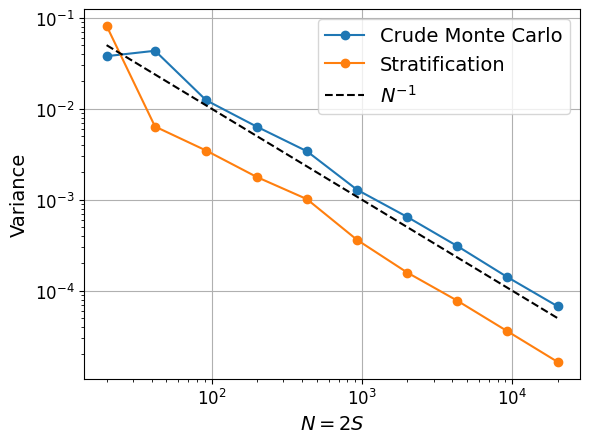

In [15]:
plt.loglog(2 * S_arr, vars_mc, "o-", label="Crude Monte Carlo")
plt.loglog(2 * S_arr, vars_strat, "o-", label="Stratification")
plt.loglog(2 * S_arr, (2 * S_arr) ** -1.0, "k--", label="$N^{-1}$")
plt.grid()
plt.xlabel("$N = 2S$")
plt.ylabel("Variance")
plt.legend();

## Exercise 2

Consider the problem of estimating $\mu = \mathbb{E}(Z)$ for $Z=\psi(X)$ and
$X\sim U(0,1)$.

1. Show that the _randomized midpoint quadrature_ estimator
	\begin{equation*}
	\hat\mu_S := \frac{1}{S}\sum_{j=1}^{S}\psi\biggl(\frac{j-1+U_j}{S}\biggr)\;,
	\end{equation*}
	with $U_1,\dots,U_S$ i.i.d. $U(0,1)$, corresponds to a stratified
	sampling estimator of $\mu$.

    **Hint:** Consider uniform strata.
   
    **Optional:** Explain why $\hat\mu_S $ is called _randomized
		midpoint quadrature_ estimator.

The estimator $\hat\mu_S$ is a stratified sampling estimator with
  \begin{equation*}
    \Omega_j = \biggl(\frac{j-1}{S},\frac{j}{S}\biggr)\;,\quad\text{and}\quad
  N_j = 1\;,
\end{equation*}
for $j=1,\dots, S$.

The name is motivated by the close similarity to the midpoint
quadrature. That is, consider approximating $\int_0^1 \psi(x)\,dx$ by
the midpoint rule using the partition $\Omega_j$:
\begin{equation*}
  \int_0^1 \psi(x)\,dx = \sum_{j=1}^S \int_{\frac{j-1}{S}}^{\frac{j}{S}} \psi(x)\,dx
  \approx  \sum_{j=1}^S\psi\biggl(\frac{j-1}{S} + \frac{1}{2S}\biggr)\;.
\end{equation*}
Since $\mathbb{E}(U_j) = 1/2$, $\hat\mu_S$ can be viewed as a randomized
midpoint rule.

2. Suppose that $\psi\in C^1\bigl([0,1]\bigr)$. Show that the
	estimator $\hat\mu_S$, which is a Monte Carlo type
	estimator, converges with _super-canonical rate_ (i.e. faster
	than $S^{-1/2}$). Specifically, show that
	$$\sqrt{\mathbb{E}[{(\mu-\hat\mu_S)}^2]} \le c S^{-3/2}\;,$$
	for an appropriate positive constant $c<\infty$ independent of
	$S$. Determine also the constant $c$.

We compute the mean squared error of the stratified sampling
  estimator as
  \begin{equation*}
    \mathbb{E}\bigl({(\mu-\hat\mu_S)}^2\bigr) = \mathbb{V}\textrm{ar}(\hat\mu_S) = S^{-2}\sum_{j=1}^S\mathbb{V}\textrm{ar}\biggl[\psi\biggl(\frac{j-1}{S} + \frac{U_j}{S}\biggr)\biggr]\;.
  \end{equation*}
  To quantify the variance term, we linearize the function $\psi$
  around  the point $(j-1)/S$, which yields
  \begin{equation*}
    \mathbb{V}\textrm{ar}\biggl[\psi\biggl(\frac{j-1}{S} + \frac{U_j}{S}\biggr)\biggr] =
    \mathbb{V}\textrm{ar}\biggl[\psi\biggl(\frac{j-1}{S}\biggr) + \psi'(\xi_j)\frac{U_j}{S}\biggr]
    = S^{-2}\mathbb{V}\textrm{ar}\bigl[ \psi'(\xi_j)U_j\bigr]\;,
  \end{equation*}
  for some $\xi_j$ between $(j-1)/S$ and $(j-1+U_j)/S$. From the
  hypothesis, it follows that
  $\mathbb{V}\textrm{ar}\bigl[ \psi'(\xi_j)U_j\bigr] \le C^2/3$ for all $j=1,\dots, S$,
  where $C = \sup_{x\in [0,1]}\lvert\psi'(x) \rvert$. Consequently, we
  find that
  \begin{equation*}
    \mathbb{E}\bigl({(\mu-\hat\mu_S)}^2\bigr) \le \frac{C^2}{3} S^{-3}\;,
  \end{equation*}
  as required.   

## Exercise 3

1. Consider the random variable $Z = 4\, \mathbb{I}_{\{U_1^2 + U_2^2\le 1\}}$ with $U_1,U_2 \overset{\text{i.i.d.}}{\sim} \mathcal{U}(0,1)$, so that $\mathbb{E}(Z) = \pi$. Consider the control variates $\tilde{Z}_{\alpha,i} = Z - \alpha(Y_i-\mathbb{E}(Y_i))$ where the controls $Y_i$ are given by:
$$
Y_1 := \mathbb{I}_{\{U_1 + U_2\le 1\}}\;,\quad Y_2 := \mathbb{I}_{\{U_1 + U_2\ge \sqrt{2}\}}\;,\quad\text{and}\quad Y_3 := (U_1+U_2-1)\mathbb{I}_{\{1<U_1 + U_2\le \sqrt{2}\}}\;.
$$
Estimate their respective expected variance reduction $\mathbb{V}\text{ar}(\tilde{Z}_{\alpha, i})/\mathbb{V}\text{ar}(Z)$ using $N= 10^6$ simulations.

    **Hint:** The expectations for the control variates are given by
    - $\mathbb{E}(Y_1) = 1/2$
    - $\mathbb{E}(Y_2) = 3 - 2\sqrt{2}$
    - $\mathbb{E}(Y_3) = -\frac{8\sqrt{2}}{3} +\frac{23}{6}$

A possible implementation of this problem is shown below. The predicted variance reductions
are compared to the variance of the control variates $\tilde{Z}_{\alpha}$ computed using the optimal choice
of control parameter $\alpha$ for each combination of controls. The console output is shown below.
As can be seen from the console output, the best performing case is when all three control
variates are used.

In [16]:
def control_variate_estimator(Z: np.array, Y: np.array, mean_Y: float) -> np.array:
    """
    Control variate estimation using original (`Z`) and control variate realizations (`Y`),
    as well as the expected value for Y (`mean_Y`).
    Returns the control variate estimator array.
    """
    var_Y = np.var(Y, ddof=1)
    cov_ZY = np.cov(Z, Y, ddof=1)[0, 1]
    alpha = cov_ZY / var_Y
    Z_cv = Z - alpha * (Y - mean_Y)
    return Z_cv

In [17]:
N = 10 ** 6

U = np.random.rand(N, 2)

In [18]:
Z = 4 * (np.linalg.norm(U, axis=1) <= 1)

In [19]:
Y1 = np.sum(U, axis=1) <= 1
Y2 = np.sum(U, axis=1) >= np.sqrt(2)
Y3 = (np.sum(U, axis=1) - 1) * (1 < np.sum(U, axis=1)) * (np.sum(U, axis=1) <= np.sqrt(2))

In [20]:
mean_Y1 = 1 / 2
mean_Y2 = 3 - 2 * np.sqrt(2)
mean_Y3 = - 8 * np.sqrt(2) / 3 + 23 / 6

In [21]:
Z1 = control_variate_estimator(Z, Y1, mean_Y1)
Z2 = control_variate_estimator(Z, Y2, mean_Y2)
Z3 = control_variate_estimator(Z, Y3, mean_Y3)

In [22]:
var_red_Z1 = np.var(Z1, ddof=1) / np.var(Z, ddof=1)
var_red_Z2 = np.var(Z2, ddof=1) / np.var(Z, ddof=1)
var_red_Z3 = np.var(Z3, ddof=1) / np.var(Z, ddof=1)

In [23]:
print(f"Variance reduction using Z1: {var_red_Z1:.4f}")
print(f"Variance reduction using Z2: {var_red_Z2:.4f}")
print(f"Variance reduction using Z3: {var_red_Z3:.4f}")

Variance reduction using Z1: 0.7267
Variance reduction using Z2: 0.2412
Variance reduction using Z3: 0.9997


2. Consider again the random variable  $Z= 4\, \mathbb{I}_{\{U_1^2 + U_2^2\le 1\}}$ as in point 1.
We now wish to use multiple control variates and compare their variance reduction to the single control variate case.
Consider the control variate $\tilde{Z}_{\boldsymbol{\alpha}} = Z - \boldsymbol{\alpha} \cdot (\mathbf{Y} - \mathbb{E}(\mathbf{Y}))$ where $\boldsymbol{\alpha} \in \mathbb{R}^d$ and $\mathbf{Y}$ is a $d$-dimensional control vector.
Perform simulations and report the expected variance reduction $\mathbb{V}\text{ar}(\tilde{Z}_{\boldsymbol{\alpha}}) / \mathbb{V}\text{ar}(Z)$ for each of the following control vectors:
    \begin{equation*}
      \boldsymbol{Y}^1 := (Y_1,Y_2)^T\;,  \quad \boldsymbol{Y}^2 := (Y_1,Y_3)^T\;,  \quad
      \boldsymbol{Y}^3 := (Y_2,Y_3)^T\;,  \quad\text{and}\quad
      \boldsymbol{Y}^4 := (Y_1,Y_2,Y_3)^T\;.
    \end{equation*}
Here, the random variables $Y_i$, $i=1,2,3$ are as described in point 1.

In [24]:
def multiple_control_variate_estimator(Z: np.array, Y: List[np.array], mean_Y: List[float]) -> np.array:
    """
    Control variate estimation using original (`Z`) and control variates realizations (`Y`),
    as well as the expected values for Y (`mean_Y`).
    Returns the control variate estimator array.
    """
    cov_YY = np.cov(Y, ddof=1)
    cov_ZY = np.cov(Z, Y, ddof=1)[0, 1:]
    alpha = np.linalg.solve(cov_YY, cov_ZY)
    Z_cv = Z - np.dot(alpha, np.stack([y - mean_y for y, mean_y in zip(Y, mean_Y)]))
    return Z_cv

In [25]:
Z1 = multiple_control_variate_estimator(Z, [Y1, Y2], [mean_Y1, mean_Y2])
Z2 = multiple_control_variate_estimator(Z, [Y1, Y3], [mean_Y1, mean_Y3])
Z3 = multiple_control_variate_estimator(Z, [Y2, Y3], [mean_Y2, mean_Y3])
Z4 = multiple_control_variate_estimator(Z, [Y1, Y2, Y3], [mean_Y1, mean_Y2, mean_Y3])

In [26]:
var_red_Z1 = np.var(Z1, ddof=1) / np.var(Z, ddof=1)
var_red_Z2 = np.var(Z2, ddof=1) / np.var(Z, ddof=1)
var_red_Z3 = np.var(Z3, ddof=1) / np.var(Z, ddof=1)
var_red_Z4 = np.var(Z4, ddof=1) / np.var(Z, ddof=1)

In [27]:
print(f"Variance reduction using Z1: {var_red_Z1:.4f}")
print(f"Variance reduction using Z2: {var_red_Z2:.4f}")
print(f"Variance reduction using Z3: {var_red_Z3:.4f}")
print(f"Variance reduction using Z4: {var_red_Z4:.4f}")

Variance reduction using Z1: 0.2212
Variance reduction using Z2: 0.6189
Variance reduction using Z3: 0.1808
Variance reduction using Z4: 0.1745


3. Implement a one-shot control variate algorithm for the control vector with the best variance reduction.

In [28]:
def one_shot_best_variance(N: int, alpha: float=0.05) -> Tuple[float, float]:
    """
    Performs a one-shot Monte Carlo simulation with `N` samples using
    control variate estimation to calculate the mean and confidence interval.
    """
    U = np.random.rand(N, 2)

    Z = 4 * (np.linalg.norm(U, axis=1) <= 1)

    Y1 = np.sum(U, axis=1) <= 1
    Y2 = np.sum(U, axis=1) >= np.sqrt(2)
    Y3 = (np.sum(U, axis=1) - 1) * (1 < np.sum(U, axis=1)) * (np.sum(U, axis=1) <= np.sqrt(2))
    
    Z_cv = multiple_control_variate_estimator(Z, [Y1, Y2, Y3], [mean_Y1, mean_Y2, mean_Y3])

    mean = Z_cv.mean()
    var = Z_cv.var(ddof=1)

    cval = norm.ppf(1 - alpha / 2)
    ci = cval * var / np.sqrt(N)

    return mean, ci

In [29]:
N = 10 ** 4

mean, ci = one_shot_best_variance(N)
print(f"Control variate estimation: {mean:.3f} ± {ci:.3e}")

Control variate estimation: 3.148 ± 8.804e-03


4. **Optional:** Show that the expectations of the control variates
$$
Y_1 := \mathbb{I}_{\{U_1 + U_2\le 1\}}\;,\quad Y_2 := \mathbb{I}_{\{U_1 + U_2\ge \sqrt{2}\}}\;,\quad\text{and}\quad Y_3 := (U_1+U_2-1)\mathbb{I}_{\{1<U_1 + U_2\le \sqrt{2}\}}
$$
are indeed given by
    - $\mathbb{E}(Y_1) = 1/2$
    - $\mathbb{E}(Y_2) = 3 - 2\sqrt{2}$
    - $\mathbb{E}(Y_3) = -\frac{8\sqrt{2}}{3} +\frac{23}{6}$.


   **Hint:** Keep in mind that the probability density function for the sum of two independent random variables can be determined by performing the convolution of their individual density functions.

Given two independent and identically distributed random variables $U_1, U_2 \sim \mathcal{U}(0,1)$ with probability density functions $ f_{U_1} $ and $ f_{U_2} $ respectively, the density of $ U := U_1 + U_2 $ is obtained by the convolution of $ f_{U_1} $ and $ f_{U_2} $:

$$
f_{U}(t) = (f_{U_1} * f_{U_2})(t) = \int_{-\infty}^{\infty} f_{U_1}(t - z) f_{U_2}(z) dz.
$$

Since $ U_1 $ and $ U_2 $ are uniformly distributed, the convolution simplifies to

$$
\begin{align}
f_{U}(t) &= \int_{-\infty}^{\infty} \mathbb{I}_{\{0 \leq t - z \leq 1\}} \cdot \mathbb{I}_{\{0 \leq z \leq 1\}} dz \\
         &= \int_{-\infty}^{\infty} \mathbb{I}_{\{\max{(0, \, t-1)} \leq \,z\, \leq \min{(1, \,t)}\}} dz \\
         &= \min{(1, \,t)} - \max{(0, \,t-1)}.
\end{align}
$$

Integrating the density function $f_{U}$ yields the cumulative distribution function (CDF)

$$
F_{U}(t) = \begin{cases} 
\frac{1}{2}t^2 & \text{if } 0 \leq t < 1, \\
-\frac{1}{2}t^2 + 2t - 1 & \text{if } 1 \leq t < 2.
\end{cases}
$$

The expected values $ \mathbb{E}(Y_1) $ and $ \mathbb{E}(Y_2) $ can be directly computed using the CDF 

$$
\mathbb{E}(Y_1) = F_U(1) = \frac{1}{2},
$$

$$
\mathbb{E}(Y_2) = 1 - F_U(\sqrt{2}) = 3 - 2\sqrt{2}.
$$

For $ Y_3 $, the expected value is given by:

$$
\begin{align}
\mathbb{E}(Y_3) &= \int_{-\infty}^\infty (u - 1) \cdot \mathbb{I}_{\{1 < u \leq \sqrt{2}\}} \cdot f_U(u) du \\
                &= \int_1^{\sqrt{2}} (u - 1) (2 - u) du \\
                &= -\frac{8\sqrt{2}}{3} + \frac{23}{6}.
\end{align}
$$

## Exercise 4 (optional, no solution)

Let $Z$ be a random variable of which we would like to estimate the mean value and let $Y$ be a suitable control variate. It the mean of $Y$ is known, we can build a Control Variate Monte Carlo estimator as $$\tag{1}\hat\mu_{CV} = \frac{1}{N}\sum_i ( Z^{(i)}-\alpha (Y^{(i)}-E[Y]) ) ,\text{ with } (Z^{(i)},Y^{(i)}) \sim \text{i.i.d $(Z,Y)$}.$$

Consider now that case in which $\mathbb{E}[Y]$ is not known and we need to estimate it via sampling.

1. A first idea is to estimate $\mathbb{E}[Y]$ by the sample average estimator $\hat{\mu}_Y = \frac{1}{N} \sum_j Y^{(j)}$ using the same sample as in Eq. (1). Show that the resulting estimator is unbiased but its variance is not smaller than (actually equal to) the one of a crude Monte Carlo estimator on $Z$.

2. A second idea is to estimate $\mathbb{E}[Y]$ with an independent Monte Carlo estimator using a sample size $N_Y$.
Let us denote by $C_Z$ the cost of generating $Z^{(i)}$ and by $C_Y$ the cost of generating $Y^{(i)}$, which we assume smaller than $C_Z$, and rename the sample size $N$ used in Eq.(1) as $N_Z$. For a given total budget $C=N_Z(C_Z+C_Y) + N_YC_Y$ for this control variate estimator, determine the optimal choice of $N_Z$ and $N_Y$ and the minimal variance achievable by the above strategy.

3. Compare then the variance obtained with that of a crude Monte Carlo estimator that uses a sample size $N$ the exhausts the same total budget $C=N C_Z$.